In [52]:
import numpy as np 
from scipy import stats 
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.stats import norm
from scipy.integrate import quad
import matplotlib.colors as colors
import sys
from iminuit import Minuit
import pandas as pd

In [53]:
sys.path.append('../External_Functions')
from ExternalFunctions import Chi2Regression, BinnedLH, UnbinnedLH, simpson38
from ExternalFunctions import nice_string_output, add_text_to_ax 

In [54]:
r = np.random                         # Random generator
r.seed(42)                            # Set a random seed (but a fixed one - more on that later.)

In [55]:
def RandomGaussian(mean, sigma, size):
    return np.random.normal(loc=mean, scale=sigma, size=size)

In [56]:
def printArr(arr):
    for i in range(len(arr)):
        print(f'{i:d} : {arr[i]:.3f}')

In [57]:
def setMplParam(classNum):
    COLOUR = ['#1E90FF', '#FFBF00', '#FF6347', '#00A86B', '#5A4FCF','#D473D4', '#00CCFF']
    LINE = ['--', '-', '-.', '-', ':', '--','-']
    MARKER = ['o', '*', '^', 's', '.', 'p', 'o']
    COLOUR_EFF = COLOUR[:classNum]
    LINE_EFF = LINE[:classNum]
    MARKER_EFF = MARKER[:classNum]
    plt.rcParams['axes.prop_cycle'] = (plt.cycler(color=COLOUR_EFF) +
                                        plt.cycler(linestyle=LINE_EFF) +
                                        plt.cycler(marker=MARKER_EFF))
    plt.rcParams['lines.markersize'] = 5  # Example size
    plt.rcParams['lines.linewidth'] = 2  # Example width

    plt.rcParams['axes.labelsize'] = 20
    plt.rcParams['axes.titlesize'] = 20

    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['xtick.labelsize'] = 20
    
    plt.rcParams['ytick.direction'] = 'in'
    plt.rcParams['ytick.labelsize'] = 20
    
    plt.rcParams['legend.fontsize'] = 12

    plt.rcParams['axes.grid'] = True
    plt.rcParams['grid.alpha'] = 0.8
    plt.rcParams['grid.linestyle'] = '--'
    plt.rcParams['grid.linewidth'] = 1

    mpl.rcParams['axes.linewidth'] = 2

    mpl.rcParams['xtick.major.size'] = 7
    mpl.rcParams['xtick.major.width'] = 3
    mpl.rcParams['xtick.minor.size'] = 2
    mpl.rcParams['xtick.minor.width'] = 2

    mpl.rcParams['ytick.major.size'] = 7
    mpl.rcParams['ytick.major.width'] = 3
    mpl.rcParams['ytick.minor.size'] = 2
    mpl.rcParams['ytick.minor.width'] = 2

setMplParam(6)

In [58]:
def likelihood(arr, mean, sigma):
    # pdf_values = norm.pdf(arr, loc=mean, scale=sigma)
    # likelihood_value = np.prod(pdf_values)
    # print(f'likelihood : {likelihood:.3f}')
    product = 1
    for i in range(len(arr)):
        product *= 1/(sigma* np.sqrt(2* np.pi)) * np.exp(- (arr[i] - mean)**2 / (2 * sigma**2))
    return product


In [59]:
def ln_likelihood(arr, mean, sigma):
    # ln_pdf_values = norm.logpdf(arr, loc=mean, scale=sigma)
    # ln_likelihood = np.sum(ln_pdf_values)
    # print(f'ln likelihood : {ln_likelihood:.3f}')
    # return ln_likelihood
    sum = 0
    for i in range(len(arr)):
        sum += (np.log(1/(sigma * np.sqrt(2* np.pi))) - ((arr[i] - mean)**2 / (2 * sigma**2)))
    return sum

Error in callback <function _draw_all_if_interactive at 0x123473550> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

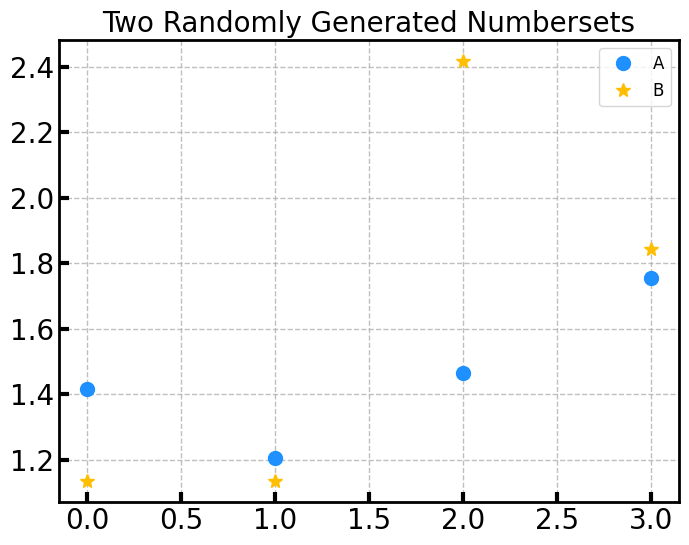

In [60]:
def plotPoints():
    x_axis = np.arange(0,4,1)
    muA, sigA = 1.25, np.sqrt(0.11)
    muB, sigB = 1.30, np.sqrt(0.50)
    randomA = RandomGaussian(muA, sigA,4)
    randomB = RandomGaussian(muB, sigB,4)
    likelihood(randomA, muA, sigA)
    likelihood(randomB, muB, sigB)
    fig, ax  = plt.subplots(figsize = (8,6))
    ax.set_title('Two Randomly Generated Numbersets')
    ax.plot(x_axis, randomA, linestyle = '', label = 'A', markersize = 10)
    ax.plot(x_axis, randomB, linestyle = '', label = 'B', markersize = 10)
    ax.legend()
plotPoints()

In [ ]:
def plotScan(func, arr, mu_range, sig_range):
    M, S = np.meshgrid(mu_range, sig_range)

    likelihoods = np.zeros(M.shape)
    for i in range(M.shape[0]):
        for j in range(M.shape[1]):
            result = func(arr, M[i, j], S[i, j])
            likelihoods[i, j] = np.exp(result) if not np.isnan(result) else 0

    fig, ax = plt.subplots(figsize=(8, 6))
    ax.set_title('Raster Scan')
    ax.set_xlabel(r'$\sigma$')
    ax.set_ylabel(r'$\mu$')

    heatmap = ax.pcolormesh(S, M, likelihoods, shading='auto', cmap='GnBu', norm=colors.LogNorm())
    cbar = fig.colorbar(heatmap, ax=ax)
    cbar.set_label('Color Scale')

    plt.show()


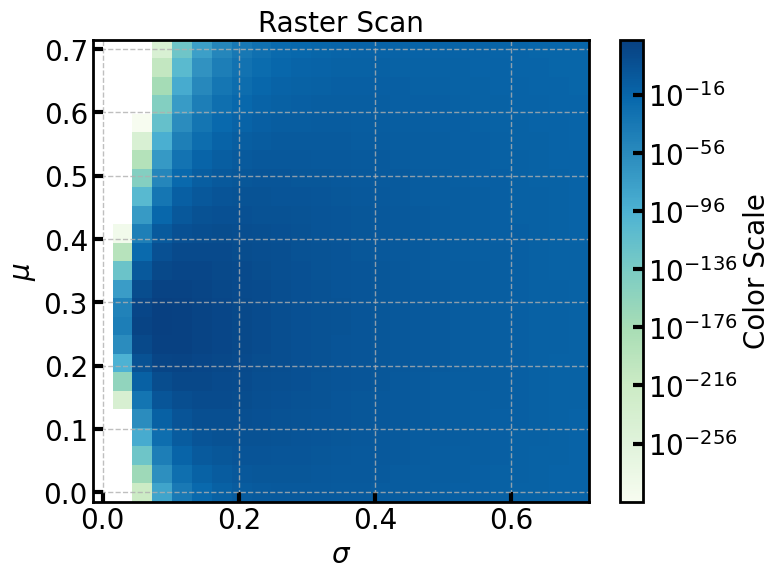

In [ ]:
def scanLLH():
    mu, sig = 0.3, 0.1
    randoms = RandomGaussian(mu, sig, 50)
    MaxMu = 0.7
    MaxSig = 0.7
    MinMu = 0
    MinSig = 0.00001
    RESOLUTION = 25
    mu_range = np.linspace(MinMu, MaxMu, RESOLUTION)
    sig_range = np.linspace(MinSig, MaxSig, RESOLUTION)
    plotScan(ln_likelihood, randoms, mu_range, sig_range)
scanLLH()
    
    

In [ ]:
def quadratic(x, alpha, beta):
    return 1 + alpha*x + beta * x**2

def normalize_quadratic(x, alpha=0.5, beta=0.5):
    integral = simpson38(quadratic, np.array([-1,1]), 1, alpha, beta)
    return quadratic(x, alpha, beta)/ integral

In [ ]:
def verifyNormalisation():
    integral = simpson38(normalize_quadratic, np.array([-1,1]), 1, 0.5, 0.5)
    print(integral)
verifyNormalisation()

1.0


In [61]:
def showMaker(ullh, ALPHA_MIN, ALPHA_MAX, BETA_MIN, BETA_MAX, N_steps):
    ALPHA_MIN, ALPHA_MAX = 0.0, 1.0
    BETA_MIN, BETA_MAX   = 0.0, 1.0
    fig, ax = plt.subplots(figsize=(10, 8))
    alpha_values = np.linspace(ALPHA_MIN, ALPHA_MAX, N_steps + 1)
    beta_values = np.linspace(BETA_MIN, BETA_MAX, N_steps + 1)
    
    # extent = [horizontal_min, horizontal_max, vertical_min, vertical_max]
    extent = [alpha_values[0], alpha_values[-1], beta_values[0], beta_values[-1]]
    
    im = ax.imshow(ullh, extent=extent, origin='lower', aspect='auto', cmap='viridis')
    ax.set_title('Raster Scan')
    ax.set_xlabel('α')
    ax.set_ylabel('β')
    plt.colorbar(im, ax=ax)
    plt.show()

# Call showMaker with ullh data from likelihood_fitting


In [62]:
def separate(df, alpha, beta):
    x_all = df['x']
    y_all = df['y']
    quad_x = normalize_quadratic(x_all, alpha, beta)
    condition = y_all <= normalize_quadratic(x_all, alpha, beta)
    df.loc[condition, 'Accept'] = 1
    df.loc[~condition, 'Accept'] = 0
    return df


In [ ]:
def RandomQuadratic(N, alpha = 0.5, beta = 0.5):
    random_x = r.uniform(-1, 1, N)
    max_y = normalize_quadratic(random_x.max(), alpha, beta)
    random_y = r.uniform(0, max_y, N)
    return separate(pd.DataFrame({'x':random_x, 'y': random_y}), alpha, beta)


In [63]:
def ln_likelihood_quad(arr, alpha, beta):
    sum = 0
    for x in arr:
        sum += -np.log(normalize_quadratic(x, alpha, beta))
    return sum

In [64]:
def likelihood_fitting(df):
    random_x = df['x']
    random_y = df['y']
    
    N_steps = 20
    ALPHA_MIN, ALPHA_MAX = 0.0, 1.0
    BETA_MIN, BETA_MAX   = 0.0, 1.0

    ALPAHA_DELTA = (ALPHA_MAX-ALPHA_MIN) / N_steps
    BETA_DELTA = (BETA_MAX-BETA_MIN) / N_steps
    
    alpha = np.zeros(N_steps + 1)
    beta  = np.zeros(N_steps + 1)
    ullh  = np.zeros((N_steps + 1, N_steps + 1))

    for i in range(N_steps + 1):
        alpha_hypo = ALPHA_MIN + i * ALPAHA_DELTA
        # alpha[i] = alpha_hypo
        for j in range(N_steps + 1):
            beta_hypo = BETA_MIN + j * BETA_DELTA
            # beta[j] = beta_hypo
            ullh[i, j] = ln_likelihood_quad(random_x, alpha_hypo, beta_hypo)
    showMaker(ullh, ALPHA_MIN, ALPHA_MAX, BETA_MIN, BETA_MAX, N_steps)


In [1]:
def plotQuadratic():
    x_axis = np.linspace(-1,1, 100)
    alpha0 = 0.5
    beta0 = 0.5
    N_proposal = 2000
    df_MC = RandomQuadratic(N_proposal, alpha0, beta0)
    fig, ax = plt.subplots(figsize=(10, 6))
    accepted = df_MC[df_MC['Accept'] == 1]
    rejected = df_MC[df_MC['Accept'] == 0]
    N_A = accepted.shape[0]
    N_R = rejected.shape[0]
    ax.scatter(accepted['x'], accepted['y'], label = f'Accepted({N_A:4d})')
    ax.scatter(rejected['x'], rejected['y'], label = f'Rejected({N_R:4d})')
    ax.plot(x_axis, normalize_quadratic(x_axis, alpha0, beta0), label='Quadratic', color='#FF6347', linestyle = '-', marker = '')
    ax.legend(loc = 'upper left')
    ax.set_title(f'Monte Carlo of the Quadratic (N = {N_proposal})')
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()
    likelihood_fitting(df_MC)

plotQuadratic()


NameError: name 'np' is not defined